In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
#import matplotlib
import pandas as pd
#import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import numpy as np
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, extract_from_infos, returns_from_cumulative
#from ensemble_strategy import ensemble_test
from technical_indicators.technical_indicators import full_rmr_moving_average, olmar_moving_average
import json

tf.__version__
print("Imports Complete")







Imports Complete


In [2]:
# Models [Framework, Window, Technical Indicators]
model_dict = [
    {
        'framework': 'TD3', 
        'window': 3, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 7, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 11, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 14, 
        'technical_indicators_flag': True
    }
]

In [3]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

model_names = []
predictor_type = 'lstm'
use_batch_norm = True
log_return = True
load_technical_indicators = True
maximum_window = max([model['window'] for model in model_dict])
dates = []

In [4]:
# Open Config
config_file_path = 'config/stock.json'   
with open(config_file_path) as f:
    config = json.load(f)
assert config != None, "Can't load config file"

actor_learning_rate = config['actor learning rate']
critic_learning_rate = config['critic learning rate']

In [5]:
# Stock History
dataset_name = 'nyse_n'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: nyse_n
Assets: ['ahp', 'alcoa', 'amer_brands', 'coke', 'comm_metals', 'dow_chem', 'Dupont', 'ford', 'ge', 'gm', 'hp', 'ibm', 'ingersoll', 'jnj', 'kimb-clark', 'kin_ark', 'Kodak', 'merck', 'mmm', 'morris', 'p_and_g', 'schlum', 'sher_will']
Stock History Shape: (23, 6430, 2)
Full Stock History Date Range: 02/01/1985 -> 30/06/2010


In [6]:
# Training/Testing Date Range
full_length = len(date_list)
train_test_ratio = 6/7
train_start_date = date_list[maximum_window]
train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
test_start_date = date_list[(int)(full_length * train_test_ratio)]
test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 22/01/1985 -> 02/11/2006 (5496 Steps)
Testing Date Range: 03/11/2006 -> 29/06/2010 (917 Steps)


In [7]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    #if technical_indicators_flag:
    technical_indicator_history = []

    # Close Price DataFrame for on-line Portfolio Selection
    temp_close_df = create_close_dataframe(history, assets, date_list)
    temp_close_df = convert_prices(temp_close_df, 'raw', True)    
    if debug:
        print('temp_close_df.shape: {}'.format(temp_close_df.shape))

    rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
    for i in range(len(assets)):
        # Create List
        ti = []
        #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
        ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

        # Turn to Array
        ti = np.vstack(ti)

        ti_reshaped = []
        for j in range(temp_close_df.shape[0]):
            ti_reshaped.append(ti[:, j])   

        technical_indicator_history.append(ti_reshaped)

    technical_indicator_history = np.array(technical_indicator_history)    
    if debug:
        print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    #else:
    #    technical_indicator_history = None
        
    return technical_indicator_history

In [8]:
if load_technical_indicators:
    # Load Technical Indicators dataset
    ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
else:
    ti_dict = {}
    distinct_window_lengths = []
    for m in model_dict:
        if m['window'] not in distinct_window_lengths:
            distinct_window_lengths.append(m['window'])
            technical_indicator_history = GenerateTechnicalIndicators(m['window'])
            ti_dict[m['window']] = technical_indicator_history
    np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [9]:
# instantiate environment
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
        
    # Add name
    if technical_indicators_flag:
        name = '{}_{}_window_{}_predictor_{}_rmr-pred'.format(dataset_name, framework, window_length, predictor_type)
    else:
        name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
    m['name'] = name
    model_names.append(name)
    
    tf.reset_default_graph()
    sess = tf.Session()
    tflearn.config.init_training_mode()
    action_dim = [nb_classes]
    
    if technical_indicators_flag:
        technical_indicator_history = ti_dict[window_length]
        state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]
    else:
        state_dim = [nb_classes, window_length]

    variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                        use_batch_norm, technical_indicators_flag)

    with tf.variable_scope(variable_scope):

        if(framework == 'DDPG'):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                               predictor_type, use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                     learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                     predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
            summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              log_return=log_return, config_file='config/stock.json', 
                              model_save_path=model_save_path, summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=True)
            
            # Add model
            m['model'] = ddpg_model

        elif(framework == 'TD3'):
            actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                  predictor_type, use_batch_norm)
            critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                     learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                     predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                       inp_actions=actor.scaled_out)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
            summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

            td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                            log_return=log_return, config_file='config/stock.json', 
                            model_save_path=model_save_path, summary_path=summary_path)
            td3_model.initialize(load_weights=True, verbose=True)
            
            # Add model
            m['model'] = td3_model


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_3/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_3_batch_norm_technica

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_7/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_7_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_7_batch_norm_technic

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_11/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_11_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_11_batch_n

INFO:tensorflow:Restoring parameters from weights/nyse_n/TD3/lstm/window_14/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading nyse_n_TD3_lstm_window_14_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: nyse_n_TD3_lstm_window_14_batch_n

-----------------
#### IN SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

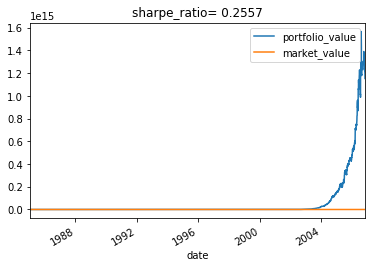

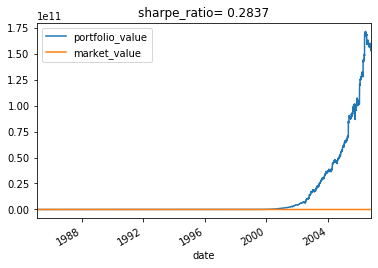

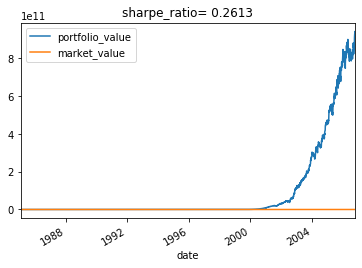

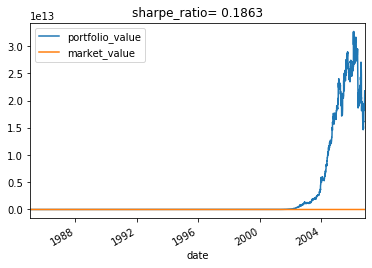

In [10]:
# Compiled Results
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
    name = m['name']
    model = m['model']
    
    if technical_indicators_flag:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length)

    
    dates, observations, _, actions, _, _, portfolio_values, in_market_portfolio_values = test_model(env, model)
    
    m['in_actions'] = actions
    m['in_portfolio_values'] = portfolio_values

#### Plot

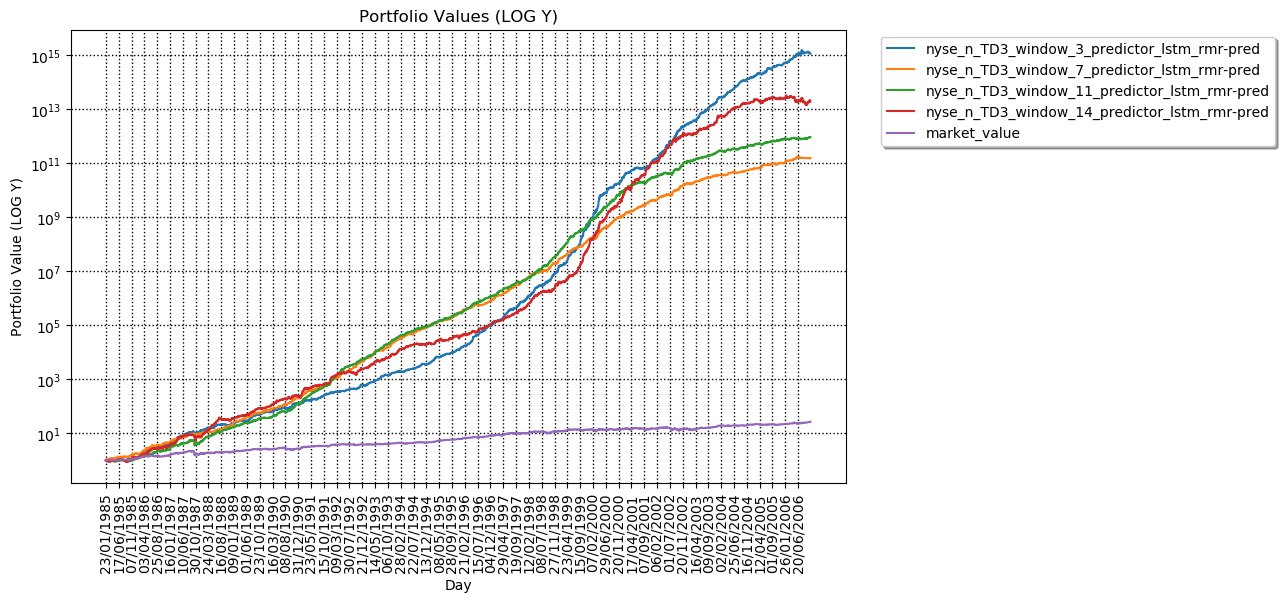

In [11]:
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Models
for m in model_dict:
    df[m['name']] = m['in_portfolio_values']
    plt.plot(df[m['name']], label=m['name'])
# Market
df['market_value'] = in_market_portfolio_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [12]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for m in model_dict:
    df = results_table_row(df, m['name'],
                           returns_from_cumulative(m['in_portfolio_values']),
                           m['in_portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(in_market_portfolio_values),
                           in_market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.6655,25.5671,47.0909,33.8889,1.153281e+15
1,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.4841,28.3501,48.9964,27.0313,1.567683e+11
2,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,0.5230,26.1600,45.4493,38.6743,9.366227e+11
3,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.6095,18.6155,32.4207,55.2066,1.953682e+13
4,market_value,0.0646,6.5845,8.4297,31.3973,2.691700e+01


-----------------
#### OUT OF SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

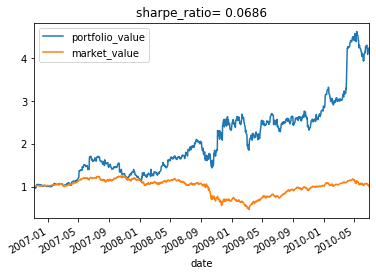

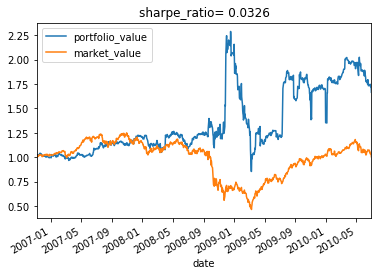

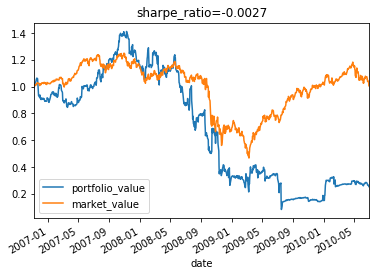

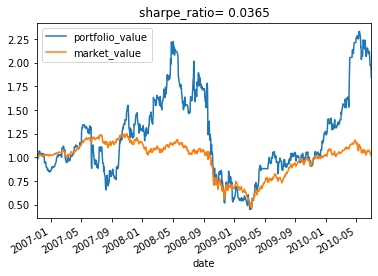

In [13]:
# Compiled Results
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
    name = m['name']
    model = m['model']
    
    if technical_indicators_flag:
        env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length)

    
    dates, observations, _, actions, _, _, portfolio_values, market_portfolio_values = test_model(env, model)
    
    m['actions'] = actions
    m['portfolio_values'] = portfolio_values

#### Plot

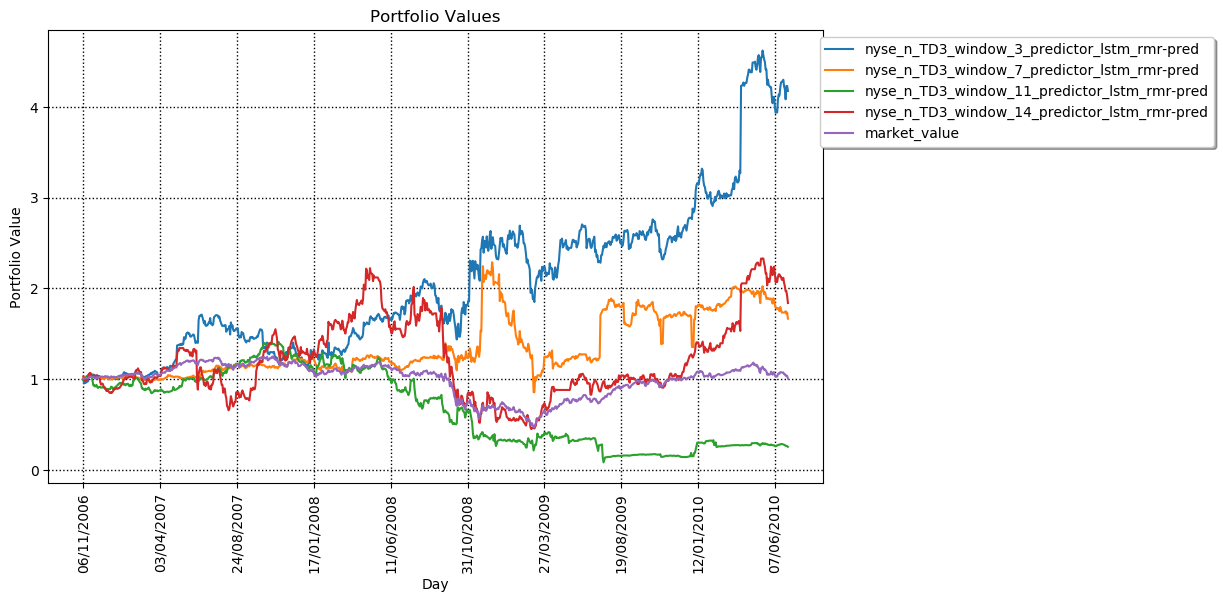

In [14]:
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'])
# Market
df['market_value'] = market_portfolio_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [15]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for m in model_dict:
    df = results_table_row(df, m['name'],
                           returns_from_cumulative(m['portfolio_values']),
                           m['portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(market_portfolio_values),
                           market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.1950,6.8767,11.1415,33.1255,4.174
1,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.1032,3.2326,4.4480,62.6060,1.665
2,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,-0.0126,-0.2488,-0.2705,94.1729,0.253
3,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
4,market_value,0.0184,0.9736,1.2451,62.6889,1.005


#### Compare with online-portfolio selection

In [16]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6430
=========BCRP=========
len(weights_array): 918
=========OLMAR=========
len(weights_array): 918
=========PAMR=========
len(weights_array): 918
=========RMR=========
len(weights_array): 918
=========WMAMR=========
len(weights_array): 918
=========EG=========
len(weights_array): 918
=========ONS=========
len(weights_array): 918
=========UP=========
len(weights_array): 918


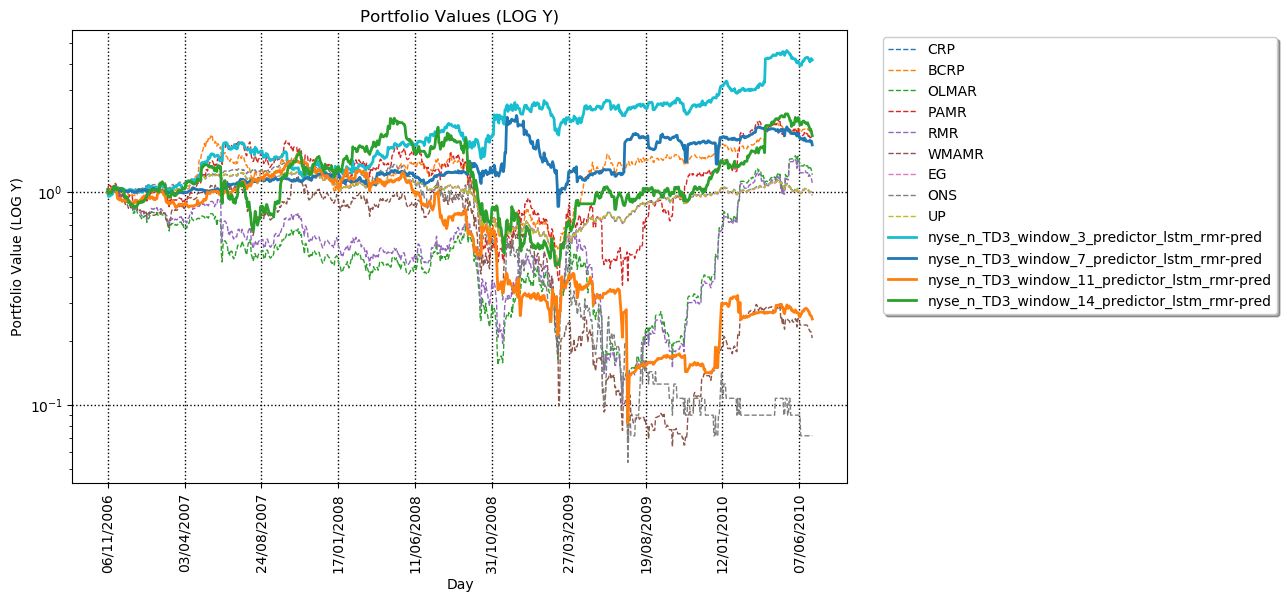

In [17]:
# Plot Together
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'], 
             linewidth=2)
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [18]:
full_model_names = model_names + olps_model_names
portfolio_values_list = []
for m in model_dict:
    portfolio_values_list.append(m['portfolio_values'])
    
portfolio_values = portfolio_values_list + olps_portfolio_values_list
results_table(full_model_names, portfolio_values)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.1950,6.8767,11.1415,33.1255,4.174
1,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.1032,3.2326,4.4480,62.6060,1.665
2,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,-0.0126,-0.2488,-0.2705,94.1729,0.253
3,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
4,CRP,0.0145,0.7684,0.9817,63.2787,0.970
5,BCRP,0.1139,3.7366,5.8033,73.2078,1.876
6,OLMAR,0.2199,3.4137,4.6782,91.4425,1.206
7,PAMR,0.1815,3.6662,5.0717,79.0335,1.797
8,RMR,0.2103,3.2596,4.5271,91.6121,1.104
9,WMAMR,0.0236,0.3772,0.4779,94.6415,0.206


--------------
## Ensemble

In [19]:

def _ensemble_test(env, model_names, model_weights_list, model_portfolio_values_list, starting_model_name, window=21, action_window=1):
    # Selected Weights
    selected_actions = []
    selected_models = []
    selected_sharpe = []
    info_list = []
    
    selected_model_name = starting_model_name
    index = 0

    assert len(model_names) == len(model_weights_list), 'Number of models is to be equal to models in weights list'
    assert env.sim.steps == len(model_weights_list[0]) - 1, 'Number of steps is to be equal to weights list'

    # Start environment. Get first observation
    _, _, info = env.reset()

    # Pass through starting window with starting model
    for i in range(window):
        # Choose action/weights via selected agent
        weights = model_weights_list[model_names.index(selected_model_name)][index]
        
        selected_sharpe.append(0)
        
        # step forward in Portfolio Environment
        _, _, _, done, info, _, _ = env.step(weights)
        info_list.append(info)

        selected_actions.append(weights)
        selected_models.append(selected_model_name)

        index = index + 1
        

    # Calculate action steps based on action window
    action_steps = int((env.sim.steps - window)/action_window)

    done = False
    for i in range(action_steps):
        # Evaluate each agent via Sharpe Ratio
        sharpe_list = []
        for model_portfolio_values in model_portfolio_values_list:
            #sharpe_list.append(np.mean(returns_from_cumulative(model_portfolio_values[(index-window):index]))) 
            sharpe_list.append(sharpe(returns_from_cumulative(model_portfolio_values[(index-window):index]))) 
        
        # Select model with highest sharpe ratio
        selected_model_name = model_names[sharpe_list.index(max(sharpe_list))]

        # Select agent to record weights
        for j in range(action_window):
            # Choose action/weights via selected agent
            weights = model_weights_list[model_names.index(selected_model_name)][index]
                        
            selected_sharpe.append(max(sharpe_list))

            # step forward in Portfolio Environment
            _, _, _, done, info, _, _ = env.step(weights)
            info_list.append(info)

            selected_actions.append(weights)
            selected_models.append(selected_model_name)

            index = index + 1

    # Pass through any remainder with the last selected agent
    while not done:
        # Choose action/weights via selected agent
        weights = model_weights_list[model_names.index(selected_model_name)][index]
        
        selected_sharpe.append(max(sharpe_list))

        # step forward in Portfolio Environment
        _, _, _, done, info, _, _ = env.step(weights)
        info_list.append(info)

        selected_actions.append(weights)
        selected_models.append(selected_model_name)

        index = index + 1

    return selected_actions, selected_models, extract_from_infos(info_list, 'portfolio_value'), selected_sharpe


In [21]:
# Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length)

starting_model_name = 'nyse_n_TD3_window_14_predictor_lstm_rmr-pred'
model_names = []
model_weights_list = []
model_portfolio_values_list = []
for m in model_dict:
    model_names.append(m['name'])
    model_weights_list.append(m['actions'])
    model_portfolio_values_list.append(m['portfolio_values'])

# Select Actions
selected_actions, selected_models, ensemble_portfolio_values, selected_sharpe = _ensemble_test(env, 
                                            model_names, model_weights_list, model_portfolio_values_list, 
                                            starting_model_name, window=21, action_window=1)

In [22]:
full_model_names = ['Ensemble'] + model_names + olps_model_names
portfolio_values_list = [ensemble_portfolio_values]
for m in model_dict:
    portfolio_values_list.append(m['portfolio_values'])
    
portfolio_values = portfolio_values_list + olps_portfolio_values_list
results_table(full_model_names, portfolio_values)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,Ensemble,0.1234,3.6082,4.8759,58.8149,1.890
1,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,0.1950,6.8767,11.1415,33.1255,4.174
2,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,0.1032,3.2326,4.4480,62.6060,1.665
3,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,-0.0126,-0.2488,-0.2705,94.1729,0.253
4,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,0.1511,3.5843,5.2605,79.8014,1.838
5,CRP,0.0145,0.7684,0.9817,63.2787,0.970
6,BCRP,0.1139,3.7366,5.8033,73.2078,1.876
7,OLMAR,0.2199,3.4137,4.6782,91.4425,1.206
8,PAMR,0.1815,3.6662,5.0717,79.0335,1.797
9,RMR,0.2103,3.2596,4.5271,91.6121,1.104


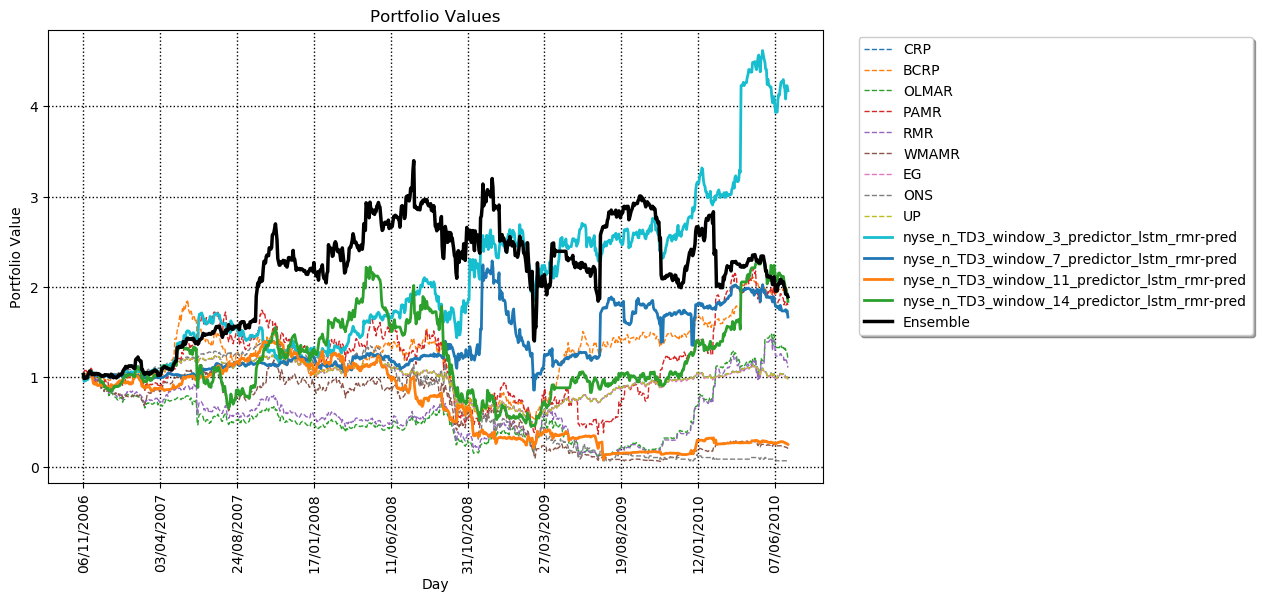

In [40]:
# Plot Together
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'], 
             linewidth=2)
    
# Ensemble
plt.plot(ensemble_portfolio_values, label='Ensemble', 
             linewidth=2.5,
            color='black')    
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [24]:
ensemble_df = pd.DataFrame()
ensemble_df['selected_models'] = selected_models
ensemble_df['selected_sharpe'] = selected_sharpe
ensemble_df['Ensemble'] = ensemble_portfolio_values
ensemble_df["Date"] = dates
ensemble_df.set_index('Date', inplace=True)
ensemble_df['index'] = list(range(len(df)))

# Our models
for m in model_dict:
    ensemble_df[m['name']] = m['portfolio_values']

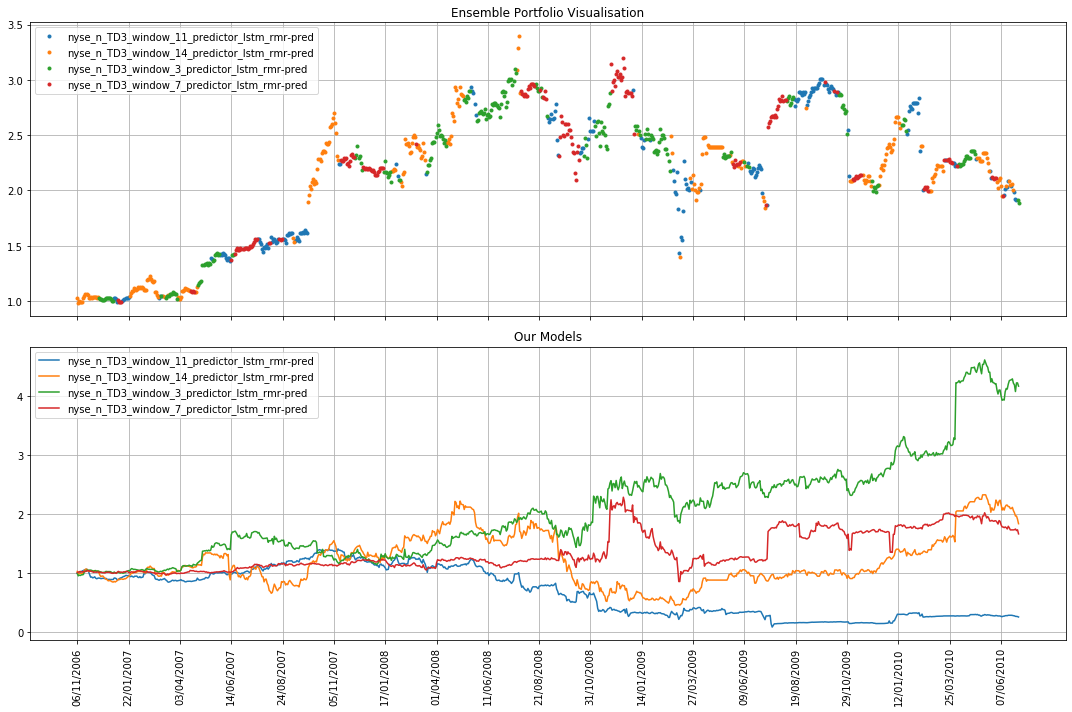

In [25]:
fig, axs = plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0].set_title('Ensemble Portfolio Visualisation')
groups = ensemble_df.groupby("selected_models")
for name, group in groups:
    axs[0].plot(group['index'], group['Ensemble'], marker=".", linestyle="", label=name)
axs[0].grid()
axs[0].legend()

# Main Picked Agents
axs[1].set_title('Our Models')
for name, group in groups:
    axs[1].plot(ensemble_df[name], label=name)
    
#for m in model_dict:
#    df[m['name']] = m['portfolio_values']
#    axs[1].plot(df[m['name']], label=m['name'], 
#             linewidth=2)
axs[1].grid()
axs[1].legend()

plt.xticks(np.arange(0, len(dates), 50))
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

----------------
## Rolling Analysis
1. Rolling Average Daily Yield (%) 	
2. Rolling Sharpe Ratio (%)
3. Rolling Sortino Ratio (%) 
4. Rolling Maximum Drawdown (%)

In [26]:
rolling_window = 100

##### Rolling Average Daily Yield

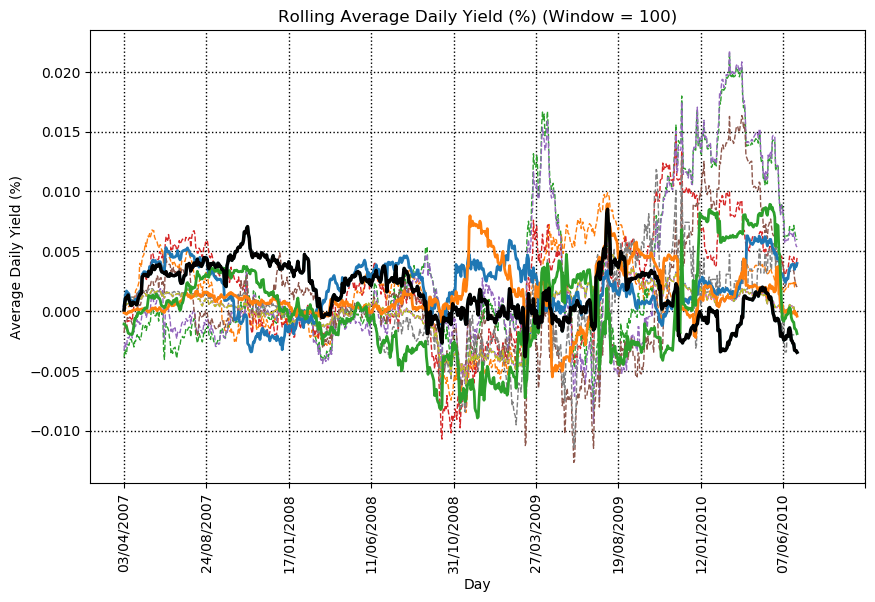

In [27]:
roll_ady_df = pd.DataFrame()
roll_ady_df["Date"] = dates
roll_ady_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Average Daily Yield (%) (Window = {})'.format(rolling_window))
plt.ylabel('Average Daily Yield (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_ady_df[olps_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_ady_df[model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
             linewidth=2)

# Ensemble
roll_ady_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_ady_df['ensemble_model'] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
plt.plot(roll_ady_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_ady_df.drop('returns', axis=1, inplace=True)

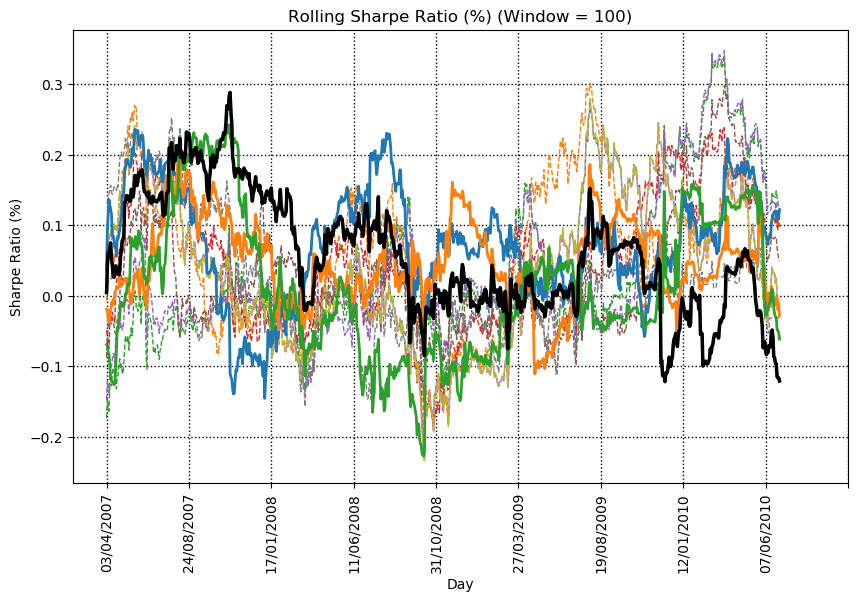

In [28]:
roll_sha_df = pd.DataFrame()
roll_sha_df["Date"] = dates
roll_sha_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sharpe Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sharpe Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sha_df[olps_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sha_df[model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
             linewidth=2)

# Ensemble
roll_sha_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_sha_df['ensemble_model'] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
plt.plot(roll_sha_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sha_df.drop('returns', axis=1, inplace=True)

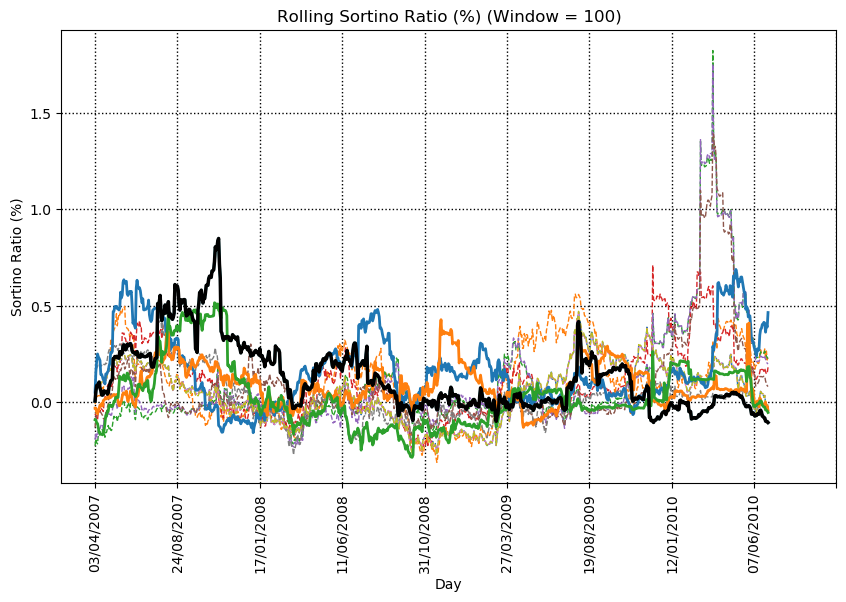

In [29]:
roll_sor_df = pd.DataFrame()
roll_sor_df["Date"] = dates
roll_sor_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sortino Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sortino Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sor_df[olps_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sor_df[model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
             linewidth=2)

# Ensemble
roll_sor_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_sor_df['ensemble_model'] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
plt.plot(roll_sor_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sor_df.drop('returns', axis=1, inplace=True)

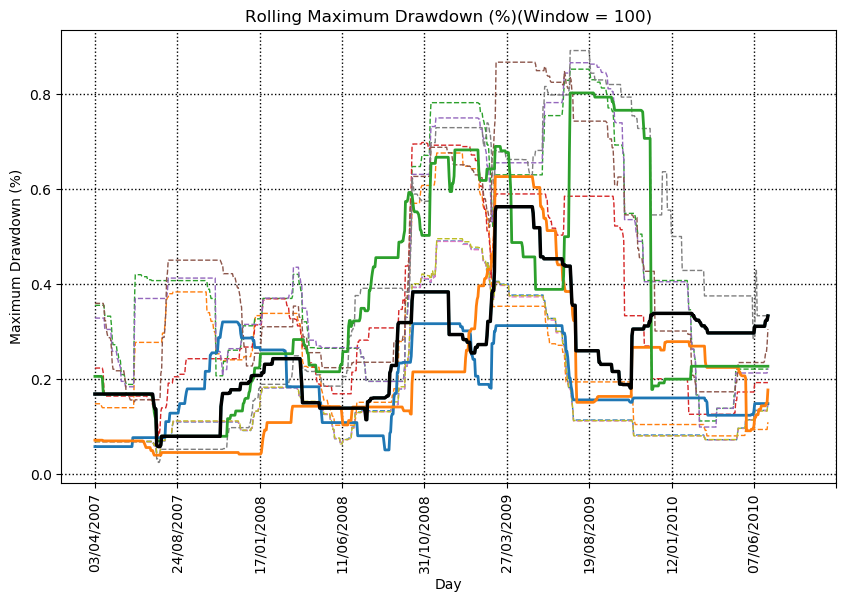

In [30]:
roll_mdd_df = pd.DataFrame()
roll_mdd_df["Date"] = dates
roll_mdd_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Maximum Drawdown (%)(Window = {})'.format(rolling_window))
plt.ylabel('Maximum Drawdown (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_mdd_df['returns'] =  olps_portfolio_values_list[i]
    roll_mdd_df[olps_model_names[i]] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_mdd_df['returns'] =  portfolio_values_list[i]
    roll_mdd_df[model_names[i]] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
             linewidth=2)

# Ensemble
roll_mdd_df['returns'] = ensemble_portfolio_values
roll_mdd_df['ensemble_model'] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
plt.plot(roll_mdd_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_mdd_df.drop('returns', axis=1, inplace=True)

In [31]:
# Average Daily Yield (%) 	Sharpe Ratio (%) 	Sortino Ratio (%) 	Maximum Drawdown (%)
# Mean and Standard deviation
temp = roll_ady_df.mean(axis = 0, skipna = True)
ady = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
ady.insert(0, "Average Daily Yield")

temp = roll_sha_df.mean(axis = 0, skipna = True)
sha = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sha.insert(0, "Sharpe Ratio")

temp = roll_sor_df.mean(axis = 0, skipna = True)
sor = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sor.insert(0, "Sortino Ratio")

temp = roll_mdd_df.mean(axis = 0, skipna = True)
mdd = (1 - (temp-temp.min())/(temp.max()-temp.min())).tolist()
mdd.insert(0, "Maximum Drawdown (inverted)")

_results_df = pd.DataFrame([ady, sha, sor, mdd], columns=["Evaluation Criteria"] + roll_ady_df.columns.tolist())

_results_df.set_index('Evaluation Criteria', inplace=True)
_results_df

,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP,nyse_n_TD3_window_3_predictor_lstm_rmr-pred,nyse_n_TD3_window_7_predictor_lstm_rmr-pred,nyse_n_TD3_window_11_predictor_lstm_rmr-pred,nyse_n_TD3_window_14_predictor_lstm_rmr-pred,ensemble_model
Evaluation Criteria,,,,,,,,,,,,,,
Average Daily Yield,0.074786,0.471920,1.000000,0.804962,0.962436,0.265804,0.069470,0.057513,0.074069,0.564354,0.743527,0.481428,0.000000,0.564354
Sharpe Ratio,0.419081,0.714513,0.360993,0.623016,0.392021,0.222049,0.413572,0.104752,0.424087,0.710792,1.000000,0.569922,0.000000,0.710792
Sortino Ratio,0.184396,0.561933,0.537642,0.575208,0.538801,0.410685,0.178088,0.000000,0.185891,0.718998,1.000000,0.429092,0.044728,0.718998
Maximum Drawdown (inverted),0.996922,0.672147,0.000000,0.355980,0.006079,0.032536,1.000000,0.100596,0.994462,0.685056,0.960373,0.910274,0.284689,0.685056


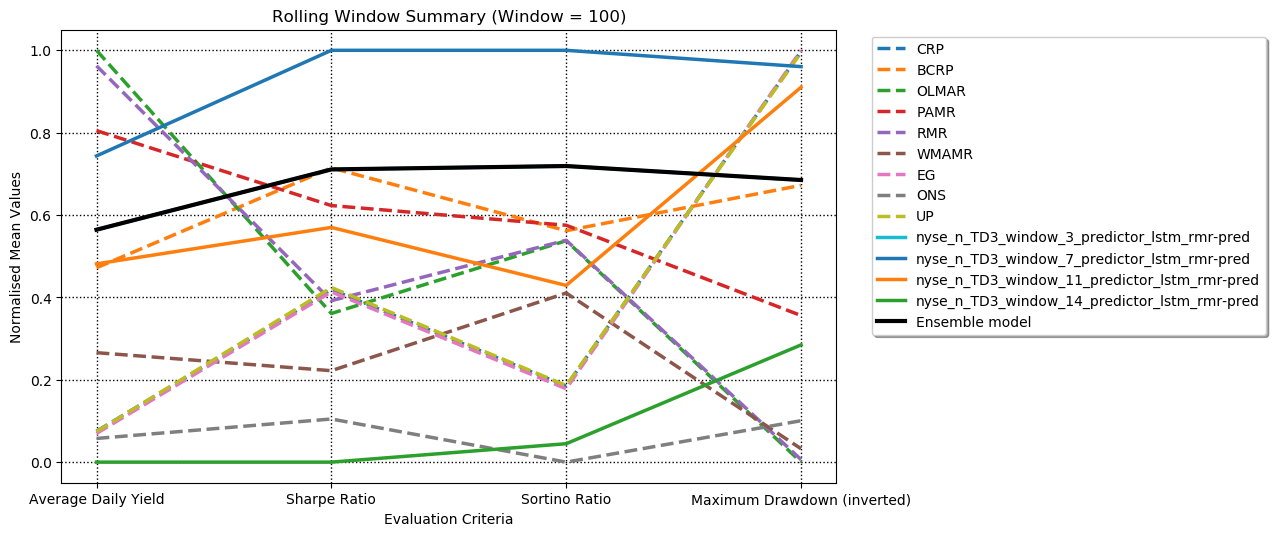

In [32]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Window Summary (Window = {})'.format(rolling_window))
plt.ylabel('Normalised Mean Values')
plt.xlabel('Evaluation Criteria')

# OLPS
for i in range(len(olps_model_names)):
    plt.plot(_results_df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=2.5, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    plt.plot(_results_df[model_names[i]], label=model_names[i], 
             linewidth=2.5)
    
# Ensemble
plt.plot(_results_df['ensemble_model'], label='Ensemble model', 
             linewidth=3,
        color='black')

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

##### Statistical summary via T-test

In [33]:
from scipy.stats import ttest_ind_from_stats

In [34]:
n = len(roll_ady_df)
our_model = 'ensemble_model'
benchmarks = olps_model_names
print("{} vs... t-tests".format(our_model))

ensemble_model vs... t-tests


In [35]:
# Average Daily Yield (%)
mean = roll_ady_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_ady_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_ady_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

ady_tstat_list = ['ADY_tstat']
ady_pvalue_list = ['ADY_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    ady_tstat_list.append(tstat)
    ady_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 12.941018794000755 | pvalue = 1.014884956026678e-36
Win
-----------------------------------------------------------------
BCRP | tstat = 1.7966272490520272 | pvalue = 0.0725593124381366
Win
-----------------------------------------------------------------
OLMAR | tstat = -5.095773075755475 | pvalue = 3.830748994311275e-07
Lose
-----------------------------------------------------------------
PAMR | tstat = -3.8792943173630836 | pvalue = 0.00010845907076430712
Lose
-----------------------------------------------------------------
RMR | tstat = -4.647931440050581 | pvalue = 3.5918800776072497e-06
Lose
-----------------------------------------------------------------
WMAMR | tstat = 4.3670135466760405 | pvalue = 1.329871936360382e-05
Win
-----------------------------------------------------------------
EG | tstat = 13.111126326977685 | pvalue = 1.3196604484410969e-37
Win
-----------------------------------------------------------------
ONS | tstat = 10.116552462909109 | pval

In [36]:
# Sharpe Ratio (%)
mean = roll_sha_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sha_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sha_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sha_tstat_list = ['SHA_tstat']
sha_pvalue_list = ['SHA_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sha_tstat_list.append(tstat)
    sha_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 3.9492283825453804 | pvalue = 8.136825345018473e-05
Win
-----------------------------------------------------------------
BCRP | tstat = -0.05068815179048162 | pvalue = 0.9595795376961931
Lose
-----------------------------------------------------------------
OLMAR | tstat = 4.721388386576442 | pvalue = 2.520127969166254e-06
Win
-----------------------------------------------------------------
PAMR | tstat = 1.2593834046130705 | pvalue = 0.20805213371493242
Win
-----------------------------------------------------------------
RMR | tstat = 4.341199202943282 | pvalue = 1.4943557932584018e-05
Win
-----------------------------------------------------------------
WMAMR | tstat = 7.4286492964962205 | pvalue = 1.6725956659979995e-13
Win
-----------------------------------------------------------------
EG | tstat = 4.0221030366877555 | pvalue = 6.0020801995636125e-05
Win
-----------------------------------------------------------------
ONS | tstat = 9.215339181578743 | pvalue = 8

In [37]:
# Sortino Ratio (%)
mean = roll_sor_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sor_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sor_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sor_tstat_list = ['SOR_tstat']
sor_pvalue_list = ['SOR_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sor_tstat_list.append(tstat)
    sor_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 9.799265419566108 | pvalue = 3.919355486477101e-22
Win
-----------------------------------------------------------------
BCRP | tstat = 2.5501375211785837 | pvalue = 0.01084872725949335
Win
-----------------------------------------------------------------
OLMAR | tstat = 2.3154988707287103 | pvalue = 0.020695496995998396
Win
-----------------------------------------------------------------
PAMR | tstat = 2.396038003280194 | pvalue = 0.01667302769009817
Win
-----------------------------------------------------------------
RMR | tstat = 2.305782809567611 | pvalue = 0.02123385248091621
Win
-----------------------------------------------------------------
WMAMR | tstat = 4.324291501508136 | pvalue = 1.6124231538007073e-05
Win
-----------------------------------------------------------------
EG | tstat = 9.931870104446075 | pvalue = 1.1175468222486914e-22
Win
-----------------------------------------------------------------
ONS | tstat = 13.923245655388763 | pvalue = 5.7776802

In [38]:
# Maximum Drawdown (%)
mean = roll_mdd_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_mdd_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_mdd_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

mdd_tstat_list = ['MDD_tstat']
mdd_pvalue_list = ['MDD_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    mdd_tstat_list.append(tstat)
    mdd_pvalue_list.append(pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat < 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 13.678327617787406 | pvalue = 1.2545451581802872e-40
Lose
-----------------------------------------------------------------
BCRP | tstat = -0.502307922025301 | pvalue = 0.6155112403848317
Win
-----------------------------------------------------------------
OLMAR | tstat = -21.73108429366646 | pvalue = 2.330204027117891e-93
Win
-----------------------------------------------------------------
PAMR | tstat = -11.59866156374306 | pvalue = 4.5585615402373924e-30
Win
-----------------------------------------------------------------
RMR | tstat = -21.33208184790087 | pvalue = 2.248959417455016e-90
Win
-----------------------------------------------------------------
WMAMR | tstat = -20.086838832013417 | pvalue = 2.8113904264084272e-81
Win
-----------------------------------------------------------------
EG | tstat = 13.837125773724681 | pvalue = 1.7137675517289527e-41
Lose
-----------------------------------------------------------------
ONS | tstat = -15.41364229013692 | pval

In [39]:
stat_df = pd.DataFrame([ady_tstat_list, ady_pvalue_list, 
                       sha_tstat_list, sha_pvalue_list, 
                       sor_tstat_list, sor_pvalue_list, 
                       mdd_tstat_list, mdd_pvalue_list], columns=['value']+benchmarks)
stat_df.set_index('value', inplace=True)
stat_df

,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP
value,,,,,,,,,
ADY_tstat,1.294102e+01,1.796627,-5.095773e+00,-3.879294e+00,-4.647931e+00,4.367014e+00,1.311113e+01,1.011655e+01,1.289057e+01
ADY_pvalue,1.014885e-36,0.072559,3.830749e-07,1.084591e-04,3.591880e-06,1.329872e-05,1.319660e-37,1.899288e-23,1.850806e-36
SHA_tstat,3.949228e+00,-0.050688,4.721388e+00,1.259383e+00,4.341199e+00,7.428649e+00,4.022103e+00,9.215339e+00,3.862679e+00
SHA_pvalue,8.136825e-05,0.959580,2.520128e-06,2.080521e-01,1.494356e-05,1.672596e-13,6.002080e-05,8.236750e-20,1.160460e-04
SOR_tstat,9.799265e+00,2.550138,2.315499e+00,2.396038e+00,2.305783e+00,4.324292e+00,9.931870e+00,1.392325e+01,9.749510e+00
SOR_pvalue,3.919355e-22,0.010849,2.069550e-02,1.667303e-02,2.123385e-02,1.612423e-05,1.117547e-22,5.777680e-42,6.252055e-22
MDD_tstat,1.367833e+01,-0.502308,-2.173108e+01,-1.159866e+01,-2.133208e+01,-2.008684e+01,1.383713e+01,-1.541364e+01,1.351009e+01
MDD_pvalue,1.254545e-40,0.615511,2.330204e-93,4.558562e-30,2.248959e-90,2.811390e-81,1.713768e-41,1.686817e-50,1.013075e-39


In [41]:
stat_df.T

value,ADY_tstat,ADY_pvalue,SHA_tstat,SHA_pvalue,SOR_tstat,SOR_pvalue,MDD_tstat,MDD_pvalue
CRP,12.941019,1.014885e-36,3.949228,8.136825e-05,9.799265,3.919355e-22,13.678328,1.254545e-40
BCRP,1.796627,7.255931e-02,-0.050688,9.595795e-01,2.550138,1.084873e-02,-0.502308,6.155112e-01
OLMAR,-5.095773,3.830749e-07,4.721388,2.520128e-06,2.315499,2.069550e-02,-21.731084,2.330204e-93
PAMR,-3.879294,1.084591e-04,1.259383,2.080521e-01,2.396038,1.667303e-02,-11.598662,4.558562e-30
RMR,-4.647931,3.591880e-06,4.341199,1.494356e-05,2.305783,2.123385e-02,-21.332082,2.248959e-90
WMAMR,4.367014,1.329872e-05,7.428649,1.672596e-13,4.324292,1.612423e-05,-20.086839,2.811390e-81
EG,13.111126,1.319660e-37,4.022103,6.002080e-05,9.931870,1.117547e-22,13.837126,1.713768e-41
ONS,10.116552,1.899288e-23,9.215339,8.236750e-20,13.923246,5.777680e-42,-15.413642,1.686817e-50
UP,12.890566,1.850806e-36,3.862679,1.160460e-04,9.749510,6.252055e-22,13.510090,1.013075e-39
